In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import dask
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load datasets

In [2]:
budgFw = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw.nc').budg_fw
budgH = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_heat.nc').budg_heat

In [3]:
flx = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_fw.nc')
nc = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_heat.nc')
flx['heat'] = nc.heat

In [4]:
budgFw = budgFw.sel(time=slice('1993-01-01','2015-12-31'))
budgH = budgH.sel(time=slice('1993-01-01','2015-12-31'))
flx = flx.sel(time=slice('1993-01-01','2015-12-31'))

In [5]:
budgFw_anom = budgFw.groupby('time.month') - budgFw.groupby('time.month').mean('time')
budgH_anom = budgH.groupby('time.month') - budgH.groupby('time.month').mean('time')
flx_anom = flx.groupby('time.month') - flx.groupby('time.month').mean('time')

In [6]:
budgFw_anom = budgFw_anom[:,:,:-1]
budgH_anom = budgH_anom[:,:,:-1]
flx_anom = flx_anom.isel(time=slice(0, -1))

### Plot

In [7]:
class OffsetYearLocator(dates.YearLocator):
    def __init__(self, *args, **kwargs):
        self.offset = kwargs.pop("offset", 0)
        dates.YearLocator.__init__(self,*args, **kwargs)
    def tick_values(self, vmin, vmax):
        ymin = self.base.le(vmin.year) * self.base.step - self.offset
        ymax = self.base.ge(vmax.year) * self.base.step + (self.base.step-self.offset)
        ticks = [vmin.replace(year=ymin, **self.replaced)]
        while True:
            dt = ticks[-1]
            if dt.year >= ymax:
                return dates.date2num(ticks)
            year = dt.year + self.base.step
            ticks.append(dt.replace(year=year, **self.replaced))

def format_xaxis(ax):

    years = dates.YearLocator(10,month=1,day=1)
    years1=OffsetYearLocator(2,month=1,day=1, offset=1)
    dfmt = dates.DateFormatter('%Y')
    dfmt1 = dates.DateFormatter('%y')

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(years1)
    ax.xaxis.set_major_formatter(dfmt)
    ax.xaxis.set_minor_formatter(dfmt1)
    ax.get_xaxis().set_tick_params(which='major', pad=15)

    plt.setp(ax.get_xmajorticklabels(), rotation=0, weight="bold", ha="center")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


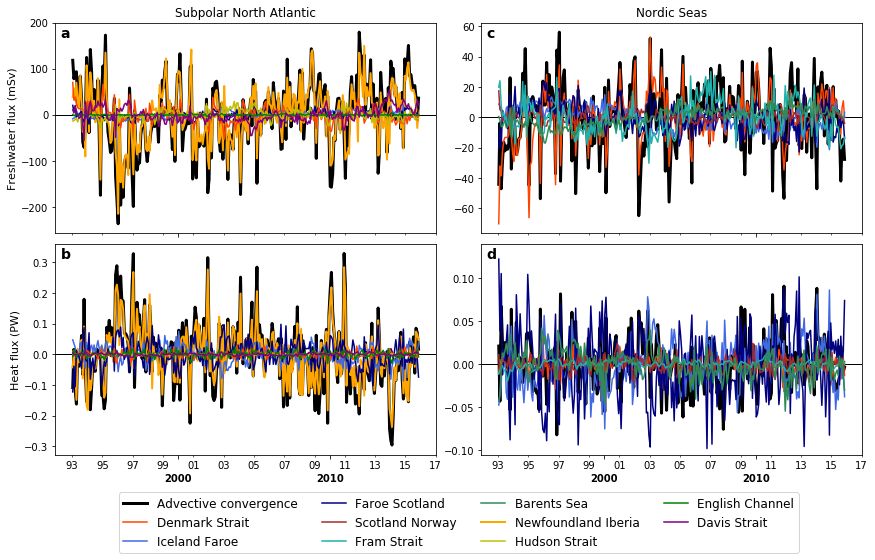

In [10]:
fig, axs = plt.subplots(2, 2,sharex=True, figsize=(14, 8))

axs[0,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='adv_ConvFw')*1e3, lw=3, color='k',
              label='Advective convergence')
axs[0,0].plot(flx_anom.time, flx_anom.sel(section='Newfoundland Iberia').fw*1e3, lw=2, color='orange',
              label='Newfoundland Iberia')
axs[0,0].plot(flx_anom.time, -flx_anom.sel(section='Iceland Faroe').fw*1e3, lw=1.5, color='royalblue',
              label='Iceland Faroe')
axs[0,0].plot(flx_anom.time, -flx_anom.sel(section='Faroe Scotland').fw*1e3, lw=1.5, color='navy',
              label='Faroe Scotland')
axs[0,0].plot(flx_anom.time, -flx_anom.sel(section='Denmark Strait').fw*1e3, lw=1.5, color='orangered',
              label='Denmark Strait')
axs[0,0].plot(flx_anom.time, -flx_anom.sel(section='Hudson Strait').fw*1e3, lw=1.5, color='y',
              label='Hudson Strait')
axs[0,0].plot(flx_anom.time, flx_anom.sel(section='English Channel').fw*1e3, lw=1.5, color='g',
              label='English Channel')
axs[0,0].plot(flx_anom.time, -flx_anom.sel(section='Davis Strait').fw*1e3, lw=1.5, color='purple',
              label='Davis Strait')
axs[0,0].set_ylabel(r'Freshwater flux (mSv)',fontsize=11)
axs[0,0].text(0.013,0.93, 'a', fontsize=14, fontweight='bold', transform=axs[0,0].transAxes)
axs[0,0].set_title(r'Subpolar North Atlantic', fontsize=12)

axs[1,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='adv_ConvH')*1e-15, lw=3, color='k',
              label='Advective convergence')
axs[1,0].plot(flx_anom.time, flx_anom.sel(section='Newfoundland Iberia').heat,lw=2,color='orange',
              label='Newfoundland Iberia')
axs[1,0].plot(flx_anom.time, -flx_anom.sel(section='Iceland Faroe').heat, lw=1.5, color='royalblue',
              label='Iceland Faroe')
axs[1,0].plot(flx_anom.time, -flx_anom.sel(section='Faroe Scotland').heat, lw=1.5, color='navy',
              label='Faroe Scotland')
axs[1,0].plot(flx_anom.time, -flx_anom.sel(section='Denmark Strait').heat, lw=1.5, color='orangered',
              label='Denmark Strait')
axs[1,0].plot(flx_anom.time, -flx_anom.sel(section='Hudson Strait').heat, lw=1.5, color='y',
              label='Hudson Strait')
axs[1,0].plot(flx_anom.time, flx_anom.sel(section='English Channel').heat, lw=1.5, color='g',
              label='English Channel')
axs[1,0].plot(flx_anom.time, -flx_anom.sel(section='Davis Strait').heat, lw=1.5, color='purple',
              label='Davis Strait')
axs[1,0].set_ylabel(r'Heat flux (PW)', fontsize=11)
axs[1,0].text(0.013,0.93, 'b', fontsize=14, fontweight='bold', transform=axs[1,0].transAxes)
format_xaxis(axs[1,0])

axs[0,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='adv_ConvFw')*1e3, lw=3, color='k',
              label='Advective convergence')
axs[0,1].plot(flx_anom.time, flx_anom.sel(section='Denmark Strait').fw*1e3, lw=1.5, color='orangered',
              label='Denmark Strait')
axs[0,1].plot(flx_anom.time, flx_anom.sel(section='Iceland Faroe').fw*1e3, lw=1.5, color='royalblue',
              label='Iceland Faroe')
axs[0,1].plot(flx_anom.time, flx_anom.sel(section='Faroe Scotland').fw*1e3, lw=1.5, color='navy',
              label='Faroe Scotland')
axs[0,1].plot(flx_anom.time, flx_anom.sel(section='Scotland Norway').fw*1e3, lw=1.5, color='brown',
              label='Scotland Norway')
axs[0,1].plot(flx_anom.time, -flx_anom.sel(section='Fram Strait').fw*1e3, lw=1.5, color='lightseagreen',
              label='Fram Strait')
axs[0,1].plot(flx_anom.time, -flx_anom.sel(section='Barents Sea').fw*1e3, lw=1.5, color='seagreen',
              label='Barents Sea')
axs[0,1].text(0.013,0.93, 'c', fontsize=14, fontweight='bold', transform=axs[0,1].transAxes)
axs[0,1].set_title(r'Nordic Seas', fontsize=12)

axs[1,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='adv_ConvH')*1e-15, lw=3, color='k',
              label='Advective convergence')
axs[1,1].plot(flx_anom.time, flx_anom.sel(section='Denmark Strait').heat, lw=1.5, color='orangered',
              label='Denmark Strait')
axs[1,1].plot(flx_anom.time, flx_anom.sel(section='Iceland Faroe').heat, lw=1.5, color='royalblue',
              label='Iceland Faroe')
axs[1,1].plot(flx_anom.time, flx_anom.sel(section='Faroe Scotland').heat, lw=1.5, color='navy',
              label='Faroe Scotland')
axs[1,1].plot(flx_anom.time, flx_anom.sel(section='Scotland Norway').heat, lw=1.5, color='brown',
              label='Scotland Norway')
axs[1,1].plot(flx_anom.time, -flx_anom.sel(section='Fram Strait').heat, lw=1.5, color='lightseagreen',
              label='Fram Strait')
axs[1,1].plot(flx_anom.time, -flx_anom.sel(section='Barents Sea').heat, lw=1.5, color='seagreen',
              label='Barents Sea')
axs[1,1].text(0.013,0.93, 'd', fontsize=14, fontweight='bold', transform=axs[1,1].transAxes)
format_xaxis(axs[1,1])
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.95, hspace=0.05, wspace=0.12)

# Add lines outlide of plot for legend
axs[1,1].plot(flx.time[:2], [-1,-1],lw=2,color='orange',label='Newfoundland Iberia')
axs[1,1].plot(flx.time[:2], [-1,-1], lw=1.5, color='y',label='Hudson Strait')
axs[1,1].plot(flx.time[:2], [-1,-1], lw=1.5, color='g',label='English Channel')
axs[1,1].plot(flx.time[:2], [-1,-1], lw=1.5, color='purple',label='Davis Strait')
axs[1,1].set_ylim([-0.105,0.14])

axs[1,1].legend(frameon=True, fancybox=True, bbox_to_anchor=(0.85, -0.15), ncol=4, fontsize=12)

plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
plt.savefig('/mnt/efs/figure.pdf')
plt.show()

### Covariance ratio

In [8]:
ecco = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/')

#### SPNA Freshwater

In [9]:
df = pd.DataFrame({'time':budgFw_anom.time,
                   'total':budgFw_anom.sel(region='spna',term='adv_ConvFw'),
                   'Newfoundland Iberia':flx_anom.sel(section='Newfoundland Iberia').fw,
                   'Iceland Faroe':-flx_anom.sel(section='Iceland Faroe').fw,
                   'Faroe Scotland':-flx_anom.sel(section='Faroe Scotland').fw,
                   'Denmark Strait':-flx_anom.sel(section='Denmark Strait').fw,
                   'Hudson Strait':-flx_anom.sel(section='Hudson Strait').fw,
                   'English Channel':flx_anom.sel(section='English Channel').fw,
                   'Davis Strait':-flx_anom.sel(section='Davis Strait').fw})

#### SPNA Heat

#### NSEA Freshwater

#### NSEA Heat

In [10]:
df.set_index('time',inplace=True)
df['dt'] = ecco.reset_coords().dt.sel(time=slice('1993-01-01','2015-11-30')).to_dataframe().dt

In [11]:
# Save with index column (time)
df.to_csv('/mnt/efs/data/eccov4_spna_fw_flx.csv', index=True)
#df.to_csv('/mnt/efs/data/eccov4_spna_heat_flx.csv', index=True)

In [23]:
# Annual
df_sub = df.loc[(df.index > '1992-12-31')&(df.index < '2015-01-01')]
df_1yr = df_sub.multiply(df_sub["dt"], axis="index").resample('1A',kind='period').sum().drop(columns=['dt'])

In [24]:
# Pentad
df_sub = df.loc[(df.index > '1994-12-31')&(df.index < '2015-01-01')]
df_5yr = df_sub.multiply(df_sub["dt"], axis="index").resample('5A',kind='period').mean().drop(columns=['dt'])

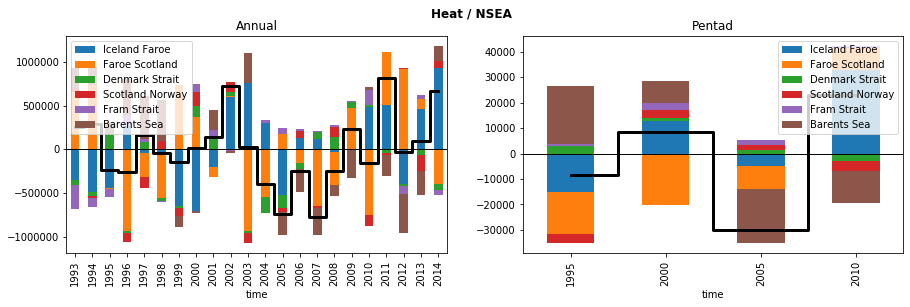

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

df_1yr.drop(columns=['total']).plot.bar(stacked=True,ax=axs[0])
axs[0].step(df_1yr.index.strftime('%Y'), df_1yr.total, where='mid', c='k', lw=3, linestyle='-')
axs[0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0].set_title('Annual')

df_5yr.drop(columns=['total']).plot.bar(stacked=True,ax=axs[1])
axs[1].step(df_5yr.index.strftime('%Y'), df_5yr.total, where='mid', c='k', lw=3, linestyle='-')
axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1].set_title('Pentad')

#fig.suptitle('Freshwater / SPNA',fontweight='bold')
#fig.suptitle('Heat / SPNA',fontweight='bold')

#fig.suptitle('Freshwater / NSEA',fontweight='bold')
fig.suptitle('Heat / NSEA',fontweight='bold')

plt.show()

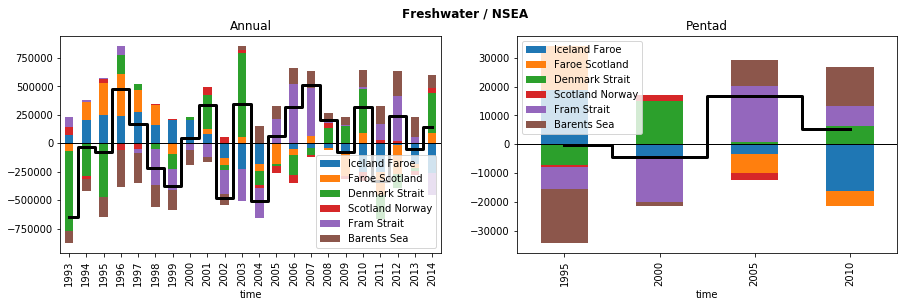

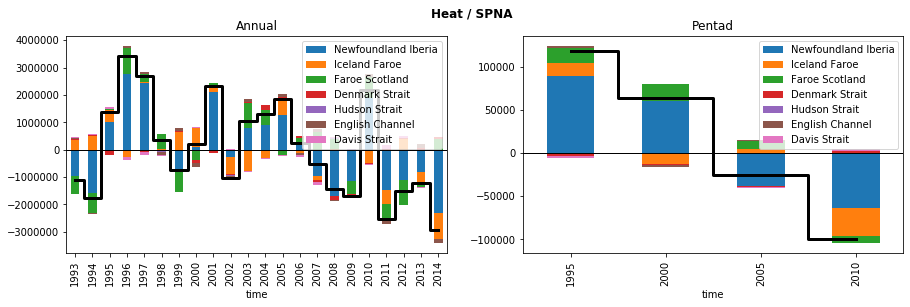

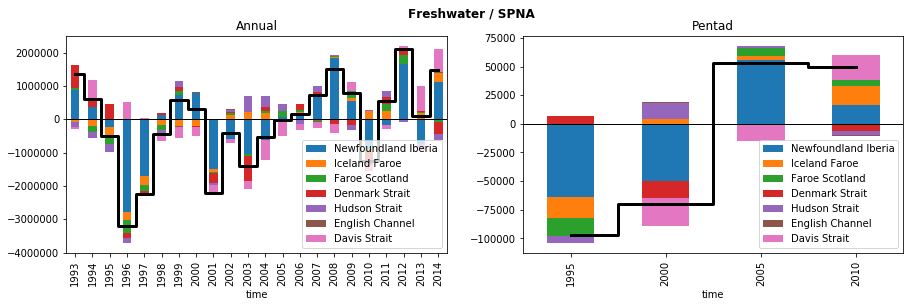

In [26]:
def cov_ratio(df):
    return pd.Series({term: df['total'].cov(df[term]) for term in df if term != 'total'})/np.var(df['total'],ddof=1)

SPNA Freshwater
                      monthly    annual    pentad
Newfoundland Iberia  0.757854  0.796560  0.688011
Iceland Faroe        0.000026  0.035054  0.139837
Faroe Scotland       0.066095  0.073148  0.108938
Denmark Strait       0.115433  0.087341 -0.012978
Hudson Strait        0.014882 -0.014931 -0.020037
English Channel      0.002601  0.002603 -0.000060
Davis Strait         0.043109  0.020223  0.096290


SPNA Heat
                      monthly    annual    pentad
Newfoundland Iberia  0.783624  0.796725  0.754056
Iceland Faroe        0.046963  0.030405  0.160774
Faroe Scotland       0.164879  0.173576  0.120660
Denmark Strait      -0.032029 -0.005494 -0.024191
Hudson Strait        0.001186  0.000494 -0.000145
English Channel      0.044556  0.025261  0.006837
Davis Strait        -0.009180 -0.020968 -0.017991


NSEA Freshwater
                  monthly    annual    pentad
Iceland Faroe    0.048005  0.012417 -0.430131
Faroe Scotland   0.184533  0.165246 -0.608266
Denmark Strait   0.556473  0.536798 -0.321204
Scotland Norway -0.031976 -0.051265 -0.169497
Fram Strait      0.193518  0.275893  1.649802
Barents Sea      0.049448  0.060912  0.879296


In [27]:
corr1mo = cov_ratio(df.drop(columns=['dt'])).to_frame(name='monthly')
corr1yr = cov_ratio(df_1yr).to_frame(name='annual')
corr5yr = cov_ratio(df_5yr).to_frame(name='pentad')

#print('SPNA Freshwater')
#print('NSEA Freshwater')
#dfFw = corr1mo.join(corr1yr.join(corr5yr))
#print(dfFw)

#print('SPNA Heat')
print('NSEA Heat')
dfH = corr1mo.join(corr1yr.join(corr5yr))
print(dfH)

NSEA Heat
                  monthly    annual    pentad
Iceland Faroe    0.410179  0.422388  0.763246
Faroe Scotland   0.559383  0.464384  0.236472
Denmark Strait  -0.117786  0.010344 -0.075389
Scotland Norway  0.061207  0.041142 -0.063642
Fram Strait      0.003032 -0.065438 -0.004942
Barents Sea      0.083986  0.127180  0.144254


In [16]:
dfFw.sort_values(by=['annual'], ascending=False)

,monthly,annual,pentad
Denmark Strait,0.556473,0.536798,-0.321204
Fram Strait,0.193518,0.275893,1.649802
Faroe Scotland,0.184533,0.165246,-0.608266
Barents Sea,0.049448,0.060912,0.879296
Iceland Faroe,0.048005,0.012417,-0.430131
Scotland Norway,-0.031976,-0.051265,-0.169497


In [28]:
dfH.sum()

monthly    1.0
annual     1.0
pentad     1.0
dtype: float64

In [29]:
#dfFw=dfFw.reindex(['Denmark Strait','Iceland Faroe','Faroe Scotland','Scotland Norway','Fram Strait','Barents Sea'])
dfH=dfH.reindex(['Denmark Strait','Iceland Faroe','Faroe Scotland','Scotland Norway','Fram Strait','Barents Sea'])

In [30]:
#dfFw.columns=pd.MultiIndex.from_tuples([('Freshwater','monthly'),('Freshwater','annual'),('Freshwater','pentad')])
dfH.columns=pd.MultiIndex.from_tuples([('Heat','monthly'),('Heat','annual'),('Heat','pentad')])

In [18]:
dfFw

Freshwater                    
                       monthly    annual    pentad
Newfoundland Iberia   0.757854  0.796560  0.688011
Denmark Strait        0.115433  0.087341 -0.012978
Iceland Faroe         0.000026  0.035054  0.139837
Faroe Scotland        0.066095  0.073148  0.108938
Davis Strait          0.043109  0.020223  0.096290
Hudson Strait         0.014882 -0.014931 -0.020037
English Channel       0.002601  0.002603 -0.000060

In [31]:
dfH

Heat                    
                      monthly    annual    pentad
Newfoundland Iberia  0.783624  0.796725  0.754056
Denmark Strait      -0.032029 -0.005494 -0.024191
Iceland Faroe        0.046963  0.030405  0.160774
Faroe Scotland       0.164879  0.173576  0.120660
Davis Strait        -0.009180 -0.020968 -0.017991
Hudson Strait        0.001186  0.000494 -0.000145
English Channel      0.044556  0.025261  0.006837

In [20]:
dfFw

Freshwater                    
                   monthly    annual    pentad
Denmark Strait    0.556473  0.536798 -0.321204
Iceland Faroe     0.048005  0.012417 -0.430131
Faroe Scotland    0.184533  0.165246 -0.608266
Scotland Norway  -0.031976 -0.051265 -0.169497
Fram Strait       0.193518  0.275893  1.649802
Barents Sea       0.049448  0.060912  0.879296

In [31]:
dfH

Heat                    
                  monthly    annual    pentad
Denmark Strait  -0.117786  0.010344 -0.075389
Iceland Faroe    0.410179  0.422388  0.763246
Faroe Scotland   0.559383  0.464384  0.236472
Scotland Norway  0.061207  0.041142 -0.063642
Fram Strait      0.003032 -0.065438 -0.004942
Barents Sea      0.083986  0.127180  0.144254

In [32]:
#df_spna = dfFw.join(dfH)
df_nsea = dfFw.join(dfH)

In [33]:
df_spna

Freshwater                          Heat            \
                       monthly    annual    pentad   monthly    annual   
Newfoundland Iberia   0.757854  0.796560  0.688011  0.783624  0.796725   
Denmark Strait        0.115433  0.087341 -0.012978 -0.032029 -0.005494   
Iceland Faroe         0.000026  0.035054  0.139837  0.046963  0.030405   
Faroe Scotland        0.066095  0.073148  0.108938  0.164879  0.173576   
Davis Strait          0.043109  0.020223  0.096290 -0.009180 -0.020968   
Hudson Strait         0.014882 -0.014931 -0.020037  0.001186  0.000494   
English Channel       0.002601  0.002603 -0.000060  0.044556  0.025261   

                               
                       pentad  
Newfoundland Iberia  0.754056  
Denmark Strait      -0.024191  
Iceland Faroe        0.160774  
Faroe Scotland       0.120660  
Davis Strait        -0.017991  
Hudson Strait       -0.000145  
English Channel      0.006837

In [33]:
df_nsea

Freshwater                          Heat                    
                   monthly    annual    pentad   monthly    annual    pentad
Denmark Strait    0.556473  0.536798 -0.321204 -0.117786  0.010344 -0.075389
Iceland Faroe     0.048005  0.012417 -0.430131  0.410179  0.422388  0.763246
Faroe Scotland    0.184533  0.165246 -0.608266  0.559383  0.464384  0.236472
Scotland Norway  -0.031976 -0.051265 -0.169497  0.061207  0.041142 -0.063642
Fram Strait       0.193518  0.275893  1.649802  0.003032 -0.065438 -0.004942
Barents Sea       0.049448  0.060912  0.879296  0.083986  0.127180  0.144254

In [34]:
from openpyxl import Workbook

In [35]:
#df_spna.to_excel('/mnt/efs/table.xlsx')
df_nsea.to_excel('/mnt/efs/table.xlsx')